In [12]:
#!/usr/bin/env python3
"""
Visualization script for Dynamo experiment results.
Aggregates results from all experiment suites and generates plots.
"""

import json
import os
import glob
import argparse
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from typing import Dict, List, Any, Optional

def load_experiment_data(results_dir: str = "results") -> List[Dict[str, Any]]:
    """
    Load all experiment results from the results directory.
    Returns a list of dictionaries containing both config and metrics.
    """
    experiments = []
    results_path = Path(results_dir)
    
    # Find all computed_metrics.json files
    for metrics_file in results_path.rglob("computed_metrics.json"):
        exp_dir = metrics_file.parent
        
        # Load metrics
        try:
            with open(metrics_file) as f:
                metrics = json.load(f)
        except Exception as e:
            print(f"Warning: Could not load {metrics_file}: {e}")
            continue
        
        # Load config
        config_file = exp_dir / "experiment_config.json"
        config = {}
        if config_file.exists():
            try:
                with open(config_file) as f:
                    config = json.load(f)
            except Exception:
                pass
        
        # Extract experiment name from directory
        exp_name = exp_dir.name
        suite_name = exp_dir.parent.name
        
        # Combine into single record
        exp_data = {
            "suite": suite_name,
            "experiment": exp_name,
            "path": str(exp_dir),
            **config,
            **metrics
        }
        experiments.append(exp_data)
    
    return experiments


In [13]:
results_dir = "results"
print(f"Loading experiments from {results_dir}...")
experiments = load_experiment_data(results_dir)
print(f"Loaded {len(experiments)} experiments")

Loading experiments from results...
Loaded 123 experiments


In [14]:
output_dir = "plots"

In [15]:
def plot_availability_vs_crash_count(experiments: List[Dict], output_dir: str = "plots"):
    """Plot availability vs crash count for different configurations, separated by RF and concurrency."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter experiments with crash_count
    crash_experiments = [e for e in experiments if e.get("crash_count") is not None and e.get("failure_mode") == "crash"]
    
    if not crash_experiments:
        print("No crash count experiments found")
        return
    
    # Group by replication_factor first, then by nodes, read_quorum_r, write_quorum_w, concurrency
    rf_values = sorted(set(e.get("replication_factor", 0) for e in crash_experiments))
    
    for rf in rf_values:
        rf_experiments = [e for e in crash_experiments if e.get("replication_factor") == rf]
        if not rf_experiments:
            continue
        
        # Get unique concurrency values
        concurrency_values = sorted(set(e.get("concurrency", 10) for e in rf_experiments))
        
        for concurrency in concurrency_values:
            conc_experiments = [e for e in rf_experiments if e.get("concurrency", 10) == concurrency]
            if not conc_experiments:
                continue
            
            # Group by nodes, read_quorum_r, write_quorum_w
            nodes_list = sorted(set(e.get("nodes", 0) for e in conc_experiments))
            r_values = sorted(set(e.get("read_quorum_r", 0) for e in conc_experiments))
            w_values = sorted(set(e.get("write_quorum_w", 0) for e in conc_experiments))
            
            # Create subplots for each (nodes, r, w) combination
            num_plots = len(nodes_list) * len(r_values) * len(w_values)
            if num_plots == 0:
                continue
            
            cols = min(3, num_plots)
            rows = (num_plots + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
            if num_plots == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            plot_idx = 0
            for nodes in nodes_list:
                for r in r_values:
                    for w in w_values:
                        subset = [e for e in conc_experiments 
                                 if e.get("nodes") == nodes and 
                                 e.get("read_quorum_r") == r and 
                                 e.get("write_quorum_w") == w]
                        
                        if not subset or plot_idx >= len(axes):
                            continue
                        
                        ax = axes[plot_idx]
                        crash_counts = sorted(set(e.get("crash_count", 0) for e in subset))
                        overall_avail = []
                        read_avail = []
                        write_avail = []
                        
                        for cc in crash_counts:
                            exp = next((e for e in subset if e.get("crash_count") == cc), None)
                            if exp and "availability" in exp:
                                overall_avail.append(exp["availability"].get("overall", 0))
                                read_avail.append(exp["availability"].get("reads", 0))
                                write_avail.append(exp["availability"].get("writes", 0))
                            else:
                                overall_avail.append(0)
                                read_avail.append(0)
                                write_avail.append(0)
                        
                        ax.plot(crash_counts, overall_avail, 'o-', label='Overall', linewidth=2, markersize=8)
                        ax.plot(crash_counts, read_avail, 's-', label='Reads', linewidth=2, markersize=8)
                        ax.plot(crash_counts, write_avail, '^-', label='Writes', linewidth=2, markersize=8)
                        ax.set_xlabel('Crash Count', fontsize=10)
                        ax.set_ylabel('Availability', fontsize=10)
                        ax.set_title(f'N={nodes}, R={r}, W={w}', fontsize=11, fontweight='bold')
                        ax.set_ylim([0, 1.05])
                        ax.grid(True, alpha=0.3)
                        if plot_idx == 0:
                            ax.legend(fontsize=8)
                        plot_idx += 1
            
            # Hide unused subplots
            for i in range(plot_idx, len(axes)):
                axes[i].set_visible(False)
            
            plt.suptitle(f'Availability vs Crash Count (RF={rf}, Concurrency={concurrency})', 
                        fontsize=14, fontweight='bold', y=1.0)
            plt.tight_layout()
            filename = f"{output_dir}/availability_vs_crash_count_rf{rf}_c{concurrency}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved: {filename}")
            plt.show()
            plt.close()

In [16]:
def plot_availability_vs_quorum(experiments: List[Dict], output_dir: str = "plots"):
    """Plot read and write availability vs quorum values for different failure modes, separated by RF (N, replication factor) and concurrency, using a monochrome colormap (Blues) with color spread 0.7-1."""
    os.makedirs(output_dir, exist_ok=True)
    
    
    # Filter experiments with quorum values
    quorum_experiments = [e for e in experiments 
                          if e.get("read_quorum_r") is not None and 
                             e.get("write_quorum_w") is not None]
    
    if not quorum_experiments:
        print("No quorum experiments found")
        return
    
    # Used for x/y and ordering
    failure_mode_order = ["none", "crash", "single_partition"]
    failure_modes_present = sorted(
        set(e.get("failure_mode", "none") for e in quorum_experiments), 
        key=lambda fm: failure_mode_order.index(fm) if fm in failure_mode_order else 99
    )
    rf_values = sorted(set(e.get("replication_factor", 0) for e in quorum_experiments))
    nodes_list = sorted(set(e.get("nodes", 0) for e in quorum_experiments))
    concurrency_values = sorted(set(e.get("concurrency", 10) for e in quorum_experiments))
    
    # Set larger font sizes
    label_fontsize = 14
    tick_fontsize = 12
    title_fontsize = 16
    subtitle_fontsize = 18
    annotation_size = 'x-large'  # for annotate, which doesn't take int
    
    for rf in rf_values:
        rf_experiments = [e for e in quorum_experiments if e.get("replication_factor") == rf]
        if not rf_experiments:
            continue
        
        for concurrency in concurrency_values:
            conc_experiments = [e for e in rf_experiments if e.get("concurrency", 10) == concurrency]
            if not conc_experiments:
                continue
            
            for nodes in nodes_list:
                subset = [e for e in conc_experiments if e.get("nodes") == nodes]
                if not subset:
                    continue
                
                n_rows = 2
                n_cols = len(failure_mode_order)
                fig, axes = plt.subplots(
                    n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows),
                    squeeze=False
                )

                fm_col_map = {fm: i for i, fm in enumerate(failure_mode_order)}
                
                for fm in failure_modes_present:
                    if fm not in fm_col_map:
                        continue  # skip if not one of ordered modes
                    col_idx = fm_col_map[fm]
                    mode_subset = [e for e in subset if e.get("failure_mode") == fm]
                    if not mode_subset:
                        for row_idx in range(n_rows):
                            axes[row_idx, col_idx].set_visible(False)
                        continue

                    r_values = sorted(set(e.get("read_quorum_r", 0) for e in mode_subset))
                    w_values = sorted(set(e.get("write_quorum_w", 0) for e in mode_subset))

                    # --- Plot read availability in row 0 ---
                    heatmap_read = np.zeros((len(r_values), len(w_values)))
                    for i, r in enumerate(r_values):
                        for j, w in enumerate(w_values):
                            exp = next((e for e in mode_subset 
                                        if e.get("read_quorum_r") == r and e.get("write_quorum_w") == w), None)
                            if exp and "availability" in exp:
                                heatmap_read[i, j] = exp["availability"].get("reads", 0)
                    ax_read = axes[0, col_idx]
                    im_read = ax_read.imshow(
                        heatmap_read, cmap='Blues', aspect='auto', vmin=0.7, vmax=1
                    )
                    ax_read.set_xticks(range(len(w_values)))
                    ax_read.set_xticklabels([f'W={w}' for w in w_values], fontsize=tick_fontsize)
                    ax_read.set_yticks(range(len(r_values)))
                    if col_idx == 0:
                        ax_read.set_yticklabels([f'R={r}' for r in r_values], fontsize=tick_fontsize)
                        ax_read.set_ylabel('Read Quorum (R)', fontsize=label_fontsize)
                    else:
                        ax_read.set_yticklabels([])
                    ax_read.set_xlabel('Write Quorum (W)', fontsize=label_fontsize)
                    ax_read.set_title(f'{fm.capitalize()} (M={nodes})', fontsize=title_fontsize, fontweight='bold')
                    cbar_read = plt.colorbar(im_read, ax=ax_read)
                    cbar_read.set_label('Read Availability', fontsize=label_fontsize)
                    cbar_read.ax.tick_params(labelsize=tick_fontsize)
                    for i in range(len(r_values)):
                        for j in range(len(w_values)):
                            ax_read.text(j, i, f'{heatmap_read[i, j]:.2f}',
                                         ha="center", va="center", color="black", fontweight='bold', fontsize=tick_fontsize + 1)
                    
                    # --- Plot write availability in row 1 ---
                    heatmap_write = np.zeros((len(r_values), len(w_values)))
                    for i, r in enumerate(r_values):
                        for j, w in enumerate(w_values):
                            exp = next((e for e in mode_subset 
                                        if e.get("read_quorum_r") == r and e.get("write_quorum_w") == w), None)
                            if exp and "availability" in exp:
                                heatmap_write[i, j] = exp["availability"].get("writes", 0)
                    ax_write = axes[1, col_idx]
                    im_write = ax_write.imshow(
                        heatmap_write, cmap='Blues', aspect='auto', vmin=0.7, vmax=1
                    )
                    ax_write.set_xticks(range(len(w_values)))
                    ax_write.set_xticklabels([f'W={w}' for w in w_values], fontsize=tick_fontsize)
                    ax_write.set_yticks(range(len(r_values)))
                    if col_idx == 0:
                        ax_write.set_yticklabels([f'R={r}' for r in r_values], fontsize=tick_fontsize)
                        ax_write.set_ylabel('Read Quorum (R)', fontsize=label_fontsize)
                    else:
                        ax_write.set_yticklabels([])
                    ax_write.set_xlabel('Write Quorum (W)', fontsize=label_fontsize)
                    cbar_write = plt.colorbar(im_write, ax=ax_write)
                    cbar_write.set_label('Write Availability', fontsize=label_fontsize)
                    cbar_write.ax.tick_params(labelsize=tick_fontsize)
                    for i in range(len(r_values)):
                        for j in range(len(w_values)):
                            ax_write.text(j, i, f'{heatmap_write[i, j]:.2f}',
                                         ha="center", va="center", color="black", fontweight='bold', fontsize=tick_fontsize + 1)

                # For unused columns (failure modes not present), hide those axes
                for col_idx in range(n_cols):
                    mode_label = failure_mode_order[col_idx]
                    if mode_label not in failure_modes_present:
                        for row_idx in range(n_rows):
                            axes[row_idx, col_idx].set_visible(False)
                
                # Row titles (y-label on leftmost)
                axes[0, 0].annotate(
                    "Read Availability",
                    xy=(0, 0.5), xytext=(-axes[0,0].yaxis.labelpad-30, 0),
                    xycoords=axes[0,0].yaxis.label, textcoords='offset points',
                    size=annotation_size, ha='right', va='center', rotation=90, fontweight='bold'
                )
                axes[1, 0].annotate(
                    "Write Availability",
                    xy=(0, 0.5), xytext=(-axes[1,0].yaxis.labelpad-30, 0),
                    xycoords=axes[1,0].yaxis.label, textcoords='offset points',
                    size=annotation_size, ha='right', va='center', rotation=90, fontweight='bold'
                )

                # Replication factor renamed to N, number of nodes as M
                plt.suptitle(
                    f'Availability vs Quorum (N={rf}, M={nodes}, Concurrency={concurrency})',
                    fontsize=subtitle_fontsize, fontweight='bold', y=1.02
                )
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                filename = f"{output_dir}/availability_quorum_heatmap_N{rf}_M{nodes}_c{concurrency}.png"
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"Saved: {filename}")
                plt.show()
                plt.close()

Saved: plots/availability_quorum_heatmap_N3_M20_c50.png


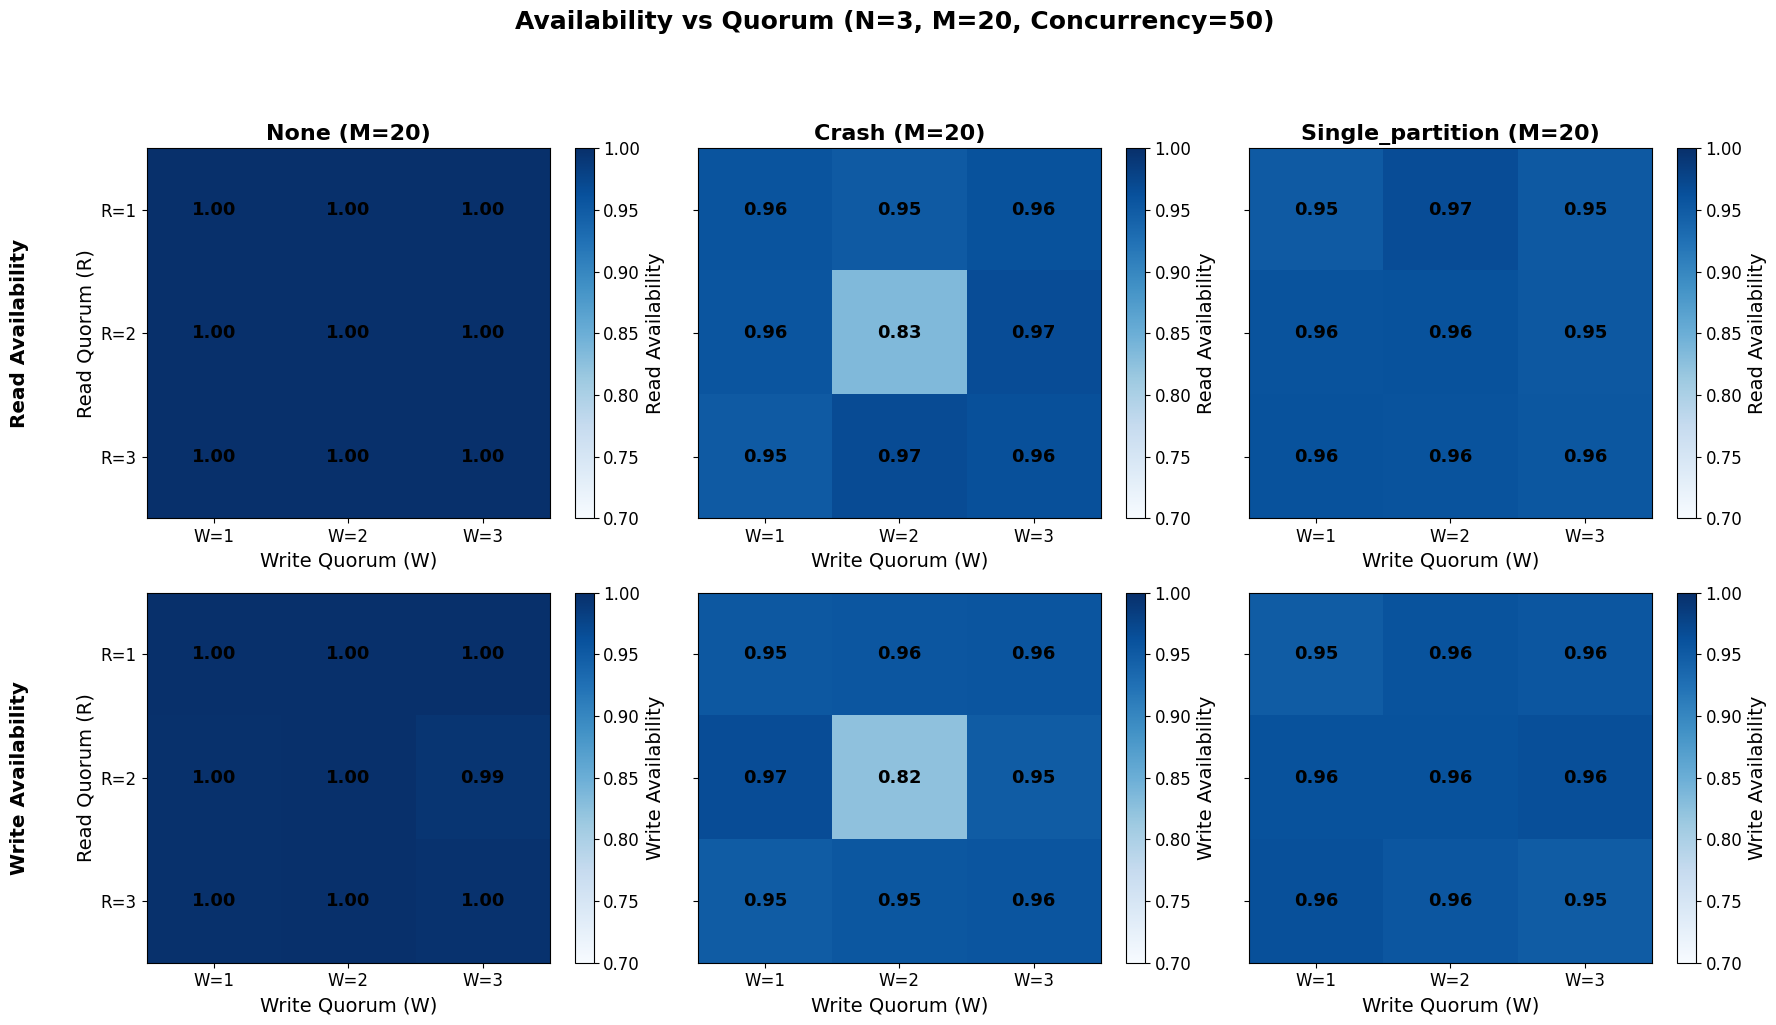

Saved: plots/availability_quorum_heatmap_N3_M30_c50.png


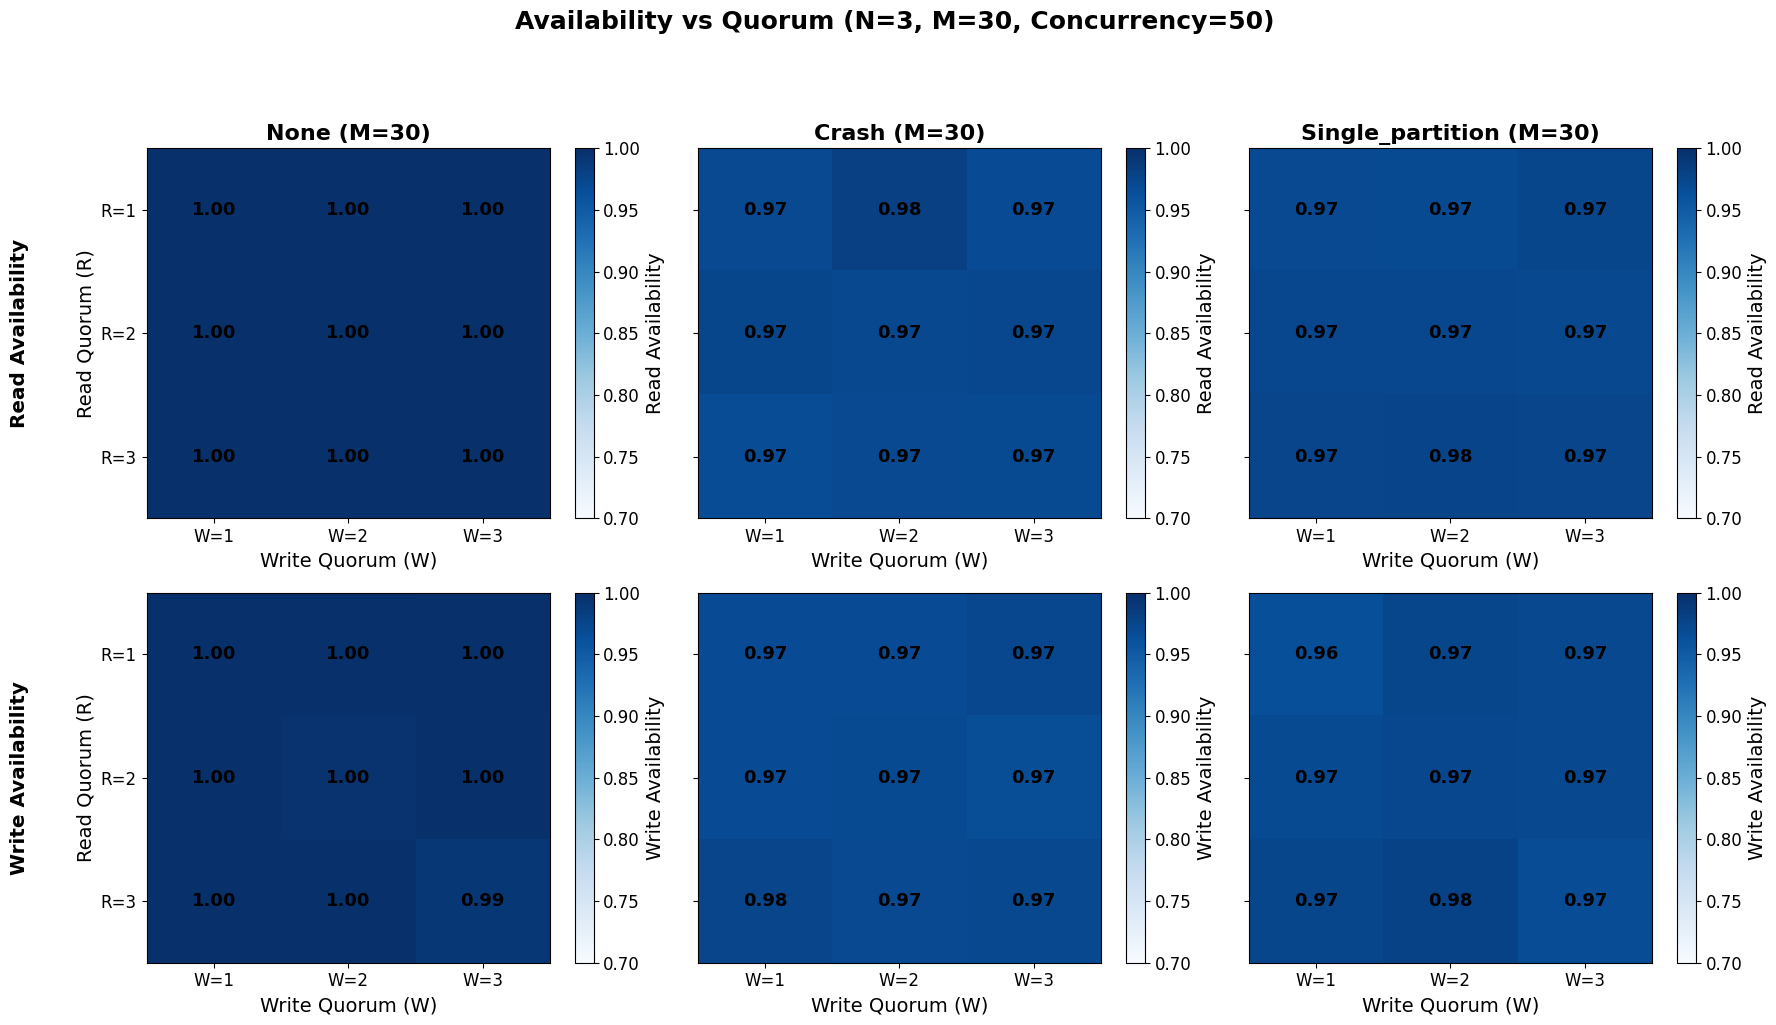

Saved: plots/availability_quorum_heatmap_N3_M20_c100.png


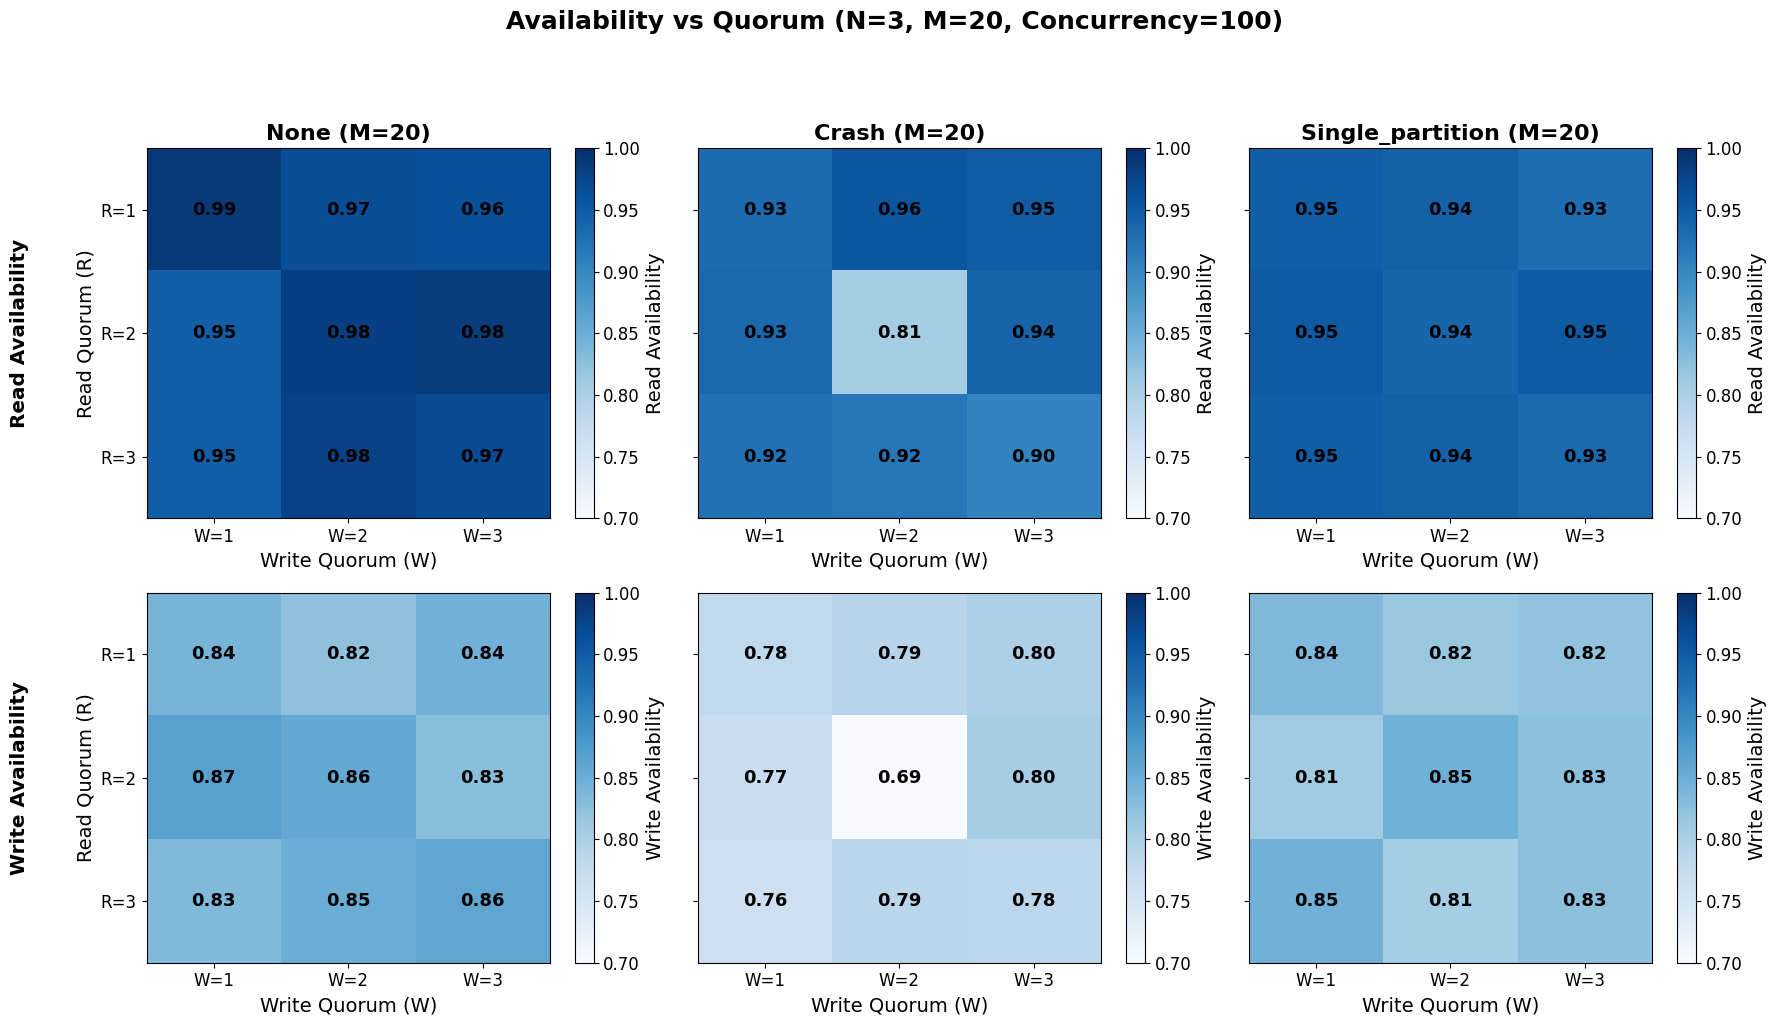

Saved: plots/availability_quorum_heatmap_N5_M20_c50.png


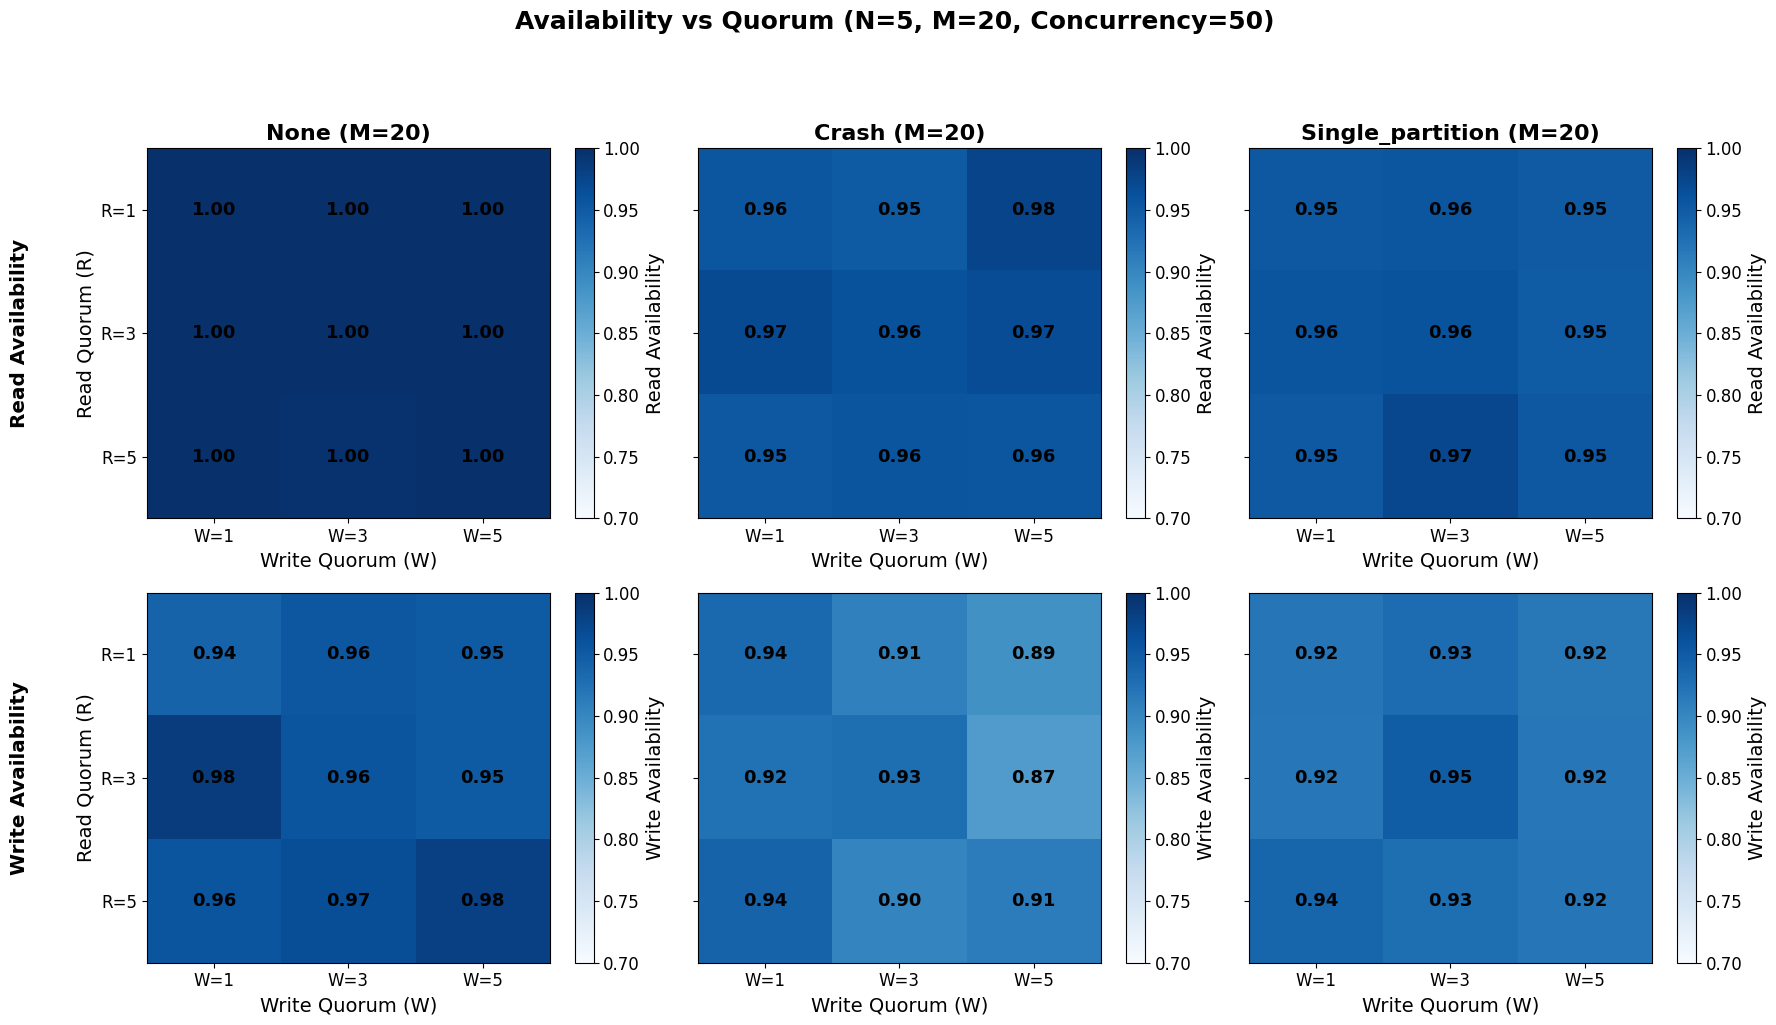

In [17]:
plot_availability_vs_quorum(experiments, output_dir)

In [8]:
def plot_availability_vs_quorum(experiments: List[Dict], output_dir: str = "plots"):
    """Plot read and write availability vs quorum values for different failure modes, separated by RF (N, replication factor) and concurrency, using a monochrome colormap (Blues) with color spread 0.7-1."""
    os.makedirs(output_dir, exist_ok=True)
    
    
    # Filter experiments with quorum values
    quorum_experiments = [e for e in experiments 
                          if e.get("read_quorum_r") is not None and 
                             e.get("write_quorum_w") is not None]
    
    if not quorum_experiments:
        print("No quorum experiments found")
        return
    
    # Used for x/y and ordering
    failure_mode_order = ["crash"]
    failure_modes_present = sorted(
        set(e.get("failure_mode", "none") for e in quorum_experiments), 
        key=lambda fm: failure_mode_order.index(fm) if fm in failure_mode_order else 99
    )
    rf_values = sorted(set(e.get("replication_factor", 0) for e in quorum_experiments))
    nodes_list = sorted(set(e.get("nodes", 0) for e in quorum_experiments))
    concurrency_values = sorted(set(e.get("concurrency", 10) for e in quorum_experiments))
    
    # Set larger font sizes
    label_fontsize = 14
    tick_fontsize = 12
    title_fontsize = 16
    subtitle_fontsize = 18
    annotation_size = 'x-large'  # for annotate, which doesn't take int
    
    for rf in rf_values:
        rf_experiments = [e for e in quorum_experiments if e.get("replication_factor") == rf]
        if not rf_experiments:
            continue
        
        for concurrency in concurrency_values:
            conc_experiments = [e for e in rf_experiments if e.get("concurrency", 10) == concurrency]
            if not conc_experiments:
                continue
            
            for nodes in nodes_list:
                subset = [e for e in conc_experiments if e.get("nodes") == nodes]
                if not subset:
                    continue
                
                n_rows = 2
                n_cols = len(failure_mode_order)
                fig, axes = plt.subplots(
                    n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows),
                    squeeze=False
                )

                fm_col_map = {fm: i for i, fm in enumerate(failure_mode_order)}
                
                for fm in failure_modes_present:
                    if fm not in fm_col_map:
                        continue  # skip if not one of ordered modes
                    col_idx = fm_col_map[fm]
                    mode_subset = [e for e in subset if e.get("failure_mode") == fm]
                    if not mode_subset:
                        for row_idx in range(n_rows):
                            axes[row_idx, col_idx].set_visible(False)
                        continue

                    r_values = sorted(set(e.get("read_quorum_r", 0) for e in mode_subset))
                    w_values = sorted(set(e.get("write_quorum_w", 0) for e in mode_subset))

                    # --- Plot read availability in row 0 ---
                    heatmap_read = np.zeros((len(r_values), len(w_values)))
                    for i, r in enumerate(r_values):
                        for j, w in enumerate(w_values):
                            exp = next((e for e in mode_subset 
                                        if e.get("read_quorum_r") == r and e.get("write_quorum_w") == w), None)
                            if exp and "availability" in exp:
                                heatmap_read[i, j] = exp["availability"].get("reads", 0)
                    ax_read = axes[0, col_idx]
                    im_read = ax_read.imshow(
                        heatmap_read, cmap='Blues', aspect='auto', vmin=0.7, vmax=1
                    )
                    ax_read.set_xticks(range(len(w_values)))
                    ax_read.set_xticklabels([f'W={w}' for w in w_values], fontsize=tick_fontsize)
                    ax_read.set_yticks(range(len(r_values)))
                    if col_idx == 0:
                        ax_read.set_yticklabels([f'R={r}' for r in r_values], fontsize=tick_fontsize)
                        ax_read.set_ylabel('Read Quorum (R)', fontsize=label_fontsize)
                    else:
                        ax_read.set_yticklabels([])
                    ax_read.set_xlabel('Write Quorum (W)', fontsize=label_fontsize)
                    ax_read.set_title(f'{fm.capitalize()} (M={nodes})', fontsize=title_fontsize, fontweight='bold')
                    cbar_read = plt.colorbar(im_read, ax=ax_read)
                    cbar_read.set_label('Read Availability', fontsize=label_fontsize)
                    cbar_read.ax.tick_params(labelsize=tick_fontsize)
                    for i in range(len(r_values)):
                        for j in range(len(w_values)):
                            ax_read.text(j, i, f'{heatmap_read[i, j]:.2f}',
                                         ha="center", va="center", color="black", fontweight='bold', fontsize=tick_fontsize + 1)
                    
                    # --- Plot write availability in row 1 ---
                    heatmap_write = np.zeros((len(r_values), len(w_values)))
                    for i, r in enumerate(r_values):
                        for j, w in enumerate(w_values):
                            exp = next((e for e in mode_subset 
                                        if e.get("read_quorum_r") == r and e.get("write_quorum_w") == w), None)
                            if exp and "availability" in exp:
                                heatmap_write[i, j] = exp["availability"].get("writes", 0)
                    ax_write = axes[1, col_idx]
                    im_write = ax_write.imshow(
                        heatmap_write, cmap='Blues', aspect='auto', vmin=0.7, vmax=1
                    )
                    ax_write.set_xticks(range(len(w_values)))
                    ax_write.set_xticklabels([f'W={w}' for w in w_values], fontsize=tick_fontsize)
                    ax_write.set_yticks(range(len(r_values)))
                    if col_idx == 0:
                        ax_write.set_yticklabels([f'R={r}' for r in r_values], fontsize=tick_fontsize)
                        ax_write.set_ylabel('Read Quorum (R)', fontsize=label_fontsize)
                    else:
                        ax_write.set_yticklabels([])
                    ax_write.set_xlabel('Write Quorum (W)', fontsize=label_fontsize)
                    cbar_write = plt.colorbar(im_write, ax=ax_write)
                    cbar_write.set_label('Write Availability', fontsize=label_fontsize)
                    cbar_write.ax.tick_params(labelsize=tick_fontsize)
                    for i in range(len(r_values)):
                        for j in range(len(w_values)):
                            ax_write.text(j, i, f'{heatmap_write[i, j]:.2f}',
                                         ha="center", va="center", color="black", fontweight='bold', fontsize=tick_fontsize + 1)

                # For unused columns (failure modes not present), hide those axes
                for col_idx in range(n_cols):
                    mode_label = failure_mode_order[col_idx]
                    if mode_label not in failure_modes_present:
                        for row_idx in range(n_rows):
                            axes[row_idx, col_idx].set_visible(False)
                
                # Row titles (y-label on leftmost)
                axes[0, 0].annotate(
                    "Read Availability",
                    xy=(0, 0.5), xytext=(-axes[0,0].yaxis.labelpad-30, 0),
                    xycoords=axes[0,0].yaxis.label, textcoords='offset points',
                    size=annotation_size, ha='right', va='center', rotation=90, fontweight='bold'
                )
                axes[1, 0].annotate(
                    "Write Availability",
                    xy=(0, 0.5), xytext=(-axes[1,0].yaxis.labelpad-30, 0),
                    xycoords=axes[1,0].yaxis.label, textcoords='offset points',
                    size=annotation_size, ha='right', va='center', rotation=90, fontweight='bold'
                )

                # Replication factor renamed to N, number of nodes as M
                plt.suptitle(
                    f'Availability vs Quorum (N={rf}, M={nodes}, Concurrency={concurrency})',
                    fontsize=subtitle_fontsize, fontweight='bold', y=1.02
                )
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                filename = f"{output_dir}/availability_quorum_heatmap_N{rf}_M{nodes}_c{concurrency}.png"
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"Saved: {filename}")
                plt.show()
                plt.close()

In [10]:
def plot_consistency_vs_quorum(experiments: List[Dict], output_dir: str = "plots"):
    """
    Plot consistency metrics (multi_version_reads and stale_read_rate) vs quorum values for different failure modes,
    separated by RF (N, replication factor) and concurrency, using a monochrome colormap (Blues) with color spread 0.7-1 
    for 'good' (low) values. Lower is better for both.
    - Row 0: multi_version_reads (number, lower is better)
    - Row 1: stale_read_rate (fraction, lower is better)
    For multi_version_reads, higher is worse (darker Blue).
    """

    os.makedirs(output_dir, exist_ok=True)

    # Font size variables (all increased)
    axis_label_fontsize = 18
    tick_fontsize = 16
    title_fontsize = 22
    colbar_label_fontsize = 18
    annotation_fontsize = 20
    cell_text_fontsize = 18
    suptitle_fontsize = 26

    # Filter experiments with quorum values
    quorum_experiments = [e for e in experiments 
                          if e.get("read_quorum_r") is not None and 
                             e.get("write_quorum_w") is not None]

    if not quorum_experiments:
        print("No quorum experiments found")
        return

    # Used for x/y and ordering
    failure_mode_order = ["none", "crash", "single_partition"]
    failure_modes_present = sorted(
        set(e.get("failure_mode", "none") for e in quorum_experiments), 
        key=lambda fm: failure_mode_order.index(fm) if fm in failure_mode_order else 99
    )
    rf_values = sorted(set(e.get("replication_factor", 0) for e in quorum_experiments))
    nodes_list = sorted(set(e.get("nodes", 0) for e in quorum_experiments))
    concurrency_values = sorted(set(e.get("concurrency", 10) for e in quorum_experiments))

    for rf in rf_values:
        rf_experiments = [e for e in quorum_experiments if e.get("replication_factor") == rf]
        if not rf_experiments:
            continue

        for concurrency in concurrency_values:
            conc_experiments = [e for e in rf_experiments if e.get("concurrency", 10) == concurrency]
            if not conc_experiments:
                continue

            for nodes in nodes_list:
                subset = [e for e in conc_experiments if e.get("nodes") == nodes]
                if not subset:
                    continue

                # Two rows: (multi_version_reads, stale_read_rate), columns = failure_modes
                n_rows = 2
                n_cols = len(failure_mode_order)
                fig, axes = plt.subplots(
                    n_rows, n_cols, figsize=(7.5 * n_cols, 6.2 * n_rows),
                    squeeze=False
                )

                fm_col_map = {fm: i for i, fm in enumerate(failure_mode_order)}
                
                # Determine color scale over all heatmap values for fairness (min/max)
                all_multi_reads = []
                all_stale_rates = []
                for fm in failure_modes_present:
                    mode_subset = [e for e in subset if e.get("failure_mode") == fm]
                    for e in mode_subset:
                        c = e.get("consistency", {})
                        all_multi_reads.append(c.get("multi_version_reads", np.nan))
                        all_stale_rates.append(c.get("stale_read_rate", np.nan))
                multi_reads_min = np.nanmin(all_multi_reads) if all_multi_reads else 0
                multi_reads_max = np.nanmax(all_multi_reads) if all_multi_reads else 1
                stale_rate_min = 0.0  # Always
                stale_rate_max = np.nanmax(all_stale_rates) if all_stale_rates else 1.0
                # For visibility, set multi_reads_min=0
                multi_reads_min = min(multi_reads_min, 0)

                for fm in failure_modes_present:
                    if fm not in fm_col_map:
                        continue  # skip if not one of ordered modes
                    col_idx = fm_col_map[fm]
                    mode_subset = [e for e in subset if e.get("failure_mode") == fm]
                    if not mode_subset:
                        for row_idx in range(n_rows):
                            axes[row_idx, col_idx].set_visible(False)
                        continue

                    r_values = sorted(set(e.get("read_quorum_r", 0) for e in mode_subset))
                    w_values = sorted(set(e.get("write_quorum_w", 0) for e in mode_subset))

                    # --- Plot multi_version_reads in row 0 ---
                    heatmap_multi = np.full((len(r_values), len(w_values)), np.nan)
                    for i, r in enumerate(r_values):
                        for j, w in enumerate(w_values):
                            exp = next((e for e in mode_subset 
                                        if e.get("read_quorum_r") == r and e.get("write_quorum_w") == w), None)
                            if exp and "consistency" in exp:
                                val = exp["consistency"].get("multi_version_reads", np.nan)
                                heatmap_multi[i, j] = val
                    ax_multi = axes[0, col_idx]
                    # Blues: so "bad" (high) are darker
                    im_multi = ax_multi.imshow(
                        heatmap_multi, cmap='Greens_r', aspect='auto', 
                        vmin=multi_reads_min, vmax=multi_reads_max
                    )
                    ax_multi.set_xticks(range(len(w_values)))
                    ax_multi.set_xticklabels([f'W={w}' for w in w_values], fontsize=tick_fontsize)
                    ax_multi.set_yticks(range(len(r_values)))
                    if col_idx == 0:
                        ax_multi.set_yticklabels([f'R={r}' for r in r_values], fontsize=tick_fontsize)
                        ax_multi.set_ylabel('Read Quorum (R)', fontsize=axis_label_fontsize)
                    else:
                        ax_multi.set_yticklabels([])
                    ax_multi.set_xlabel('Write Quorum (W)', fontsize=axis_label_fontsize)
                    ax_multi.set_title(f'{fm.capitalize()} (M={nodes})', fontsize=title_fontsize, fontweight='bold')
                    # Colorbar
                    cbar_multi = plt.colorbar(im_multi, ax=ax_multi)
                    cbar_multi.set_label('Multi-Version Reads', fontsize=colbar_label_fontsize)
                    cbar_multi.ax.tick_params(labelsize=tick_fontsize)
                    for i in range(len(r_values)):
                        for j in range(len(w_values)):
                            val = heatmap_multi[i, j]
                            if not np.isnan(val):
                                ax_multi.text(j, i, f'{val:.0f}',
                                              ha="center", va="center", color="black", fontweight='bold', fontsize=cell_text_fontsize)
                            else:
                                ax_multi.text(j, i, '-', ha="center", va="center", color="gray", fontsize=cell_text_fontsize)
                    
                    # --- Plot stale_read_rate in row 1 ---
                    heatmap_stale = np.full((len(r_values), len(w_values)), np.nan)
                    for i, r in enumerate(r_values):
                        for j, w in enumerate(w_values):
                            exp = next((e for e in mode_subset 
                                        if e.get("read_quorum_r") == r and e.get("write_quorum_w") == w), None)
                            if exp and "consistency" in exp:
                                val = exp["consistency"].get("stale_read_rate", np.nan)
                                heatmap_stale[i, j] = val
                    ax_stale = axes[1, col_idx]
                    # Change to 'Blues' instead of 'Blues_r' so that higher values are mapped to darker blue:
                    im_stale = ax_stale.imshow(
                        heatmap_stale, cmap='Greens_r', aspect='auto', 
                        vmin=stale_rate_min, vmax=max(stale_rate_max, 0.20)
                    )
                    ax_stale.set_xticks(range(len(w_values)))
                    ax_stale.set_xticklabels([f'W={w}' for w in w_values], fontsize=tick_fontsize)
                    ax_stale.set_yticks(range(len(r_values)))
                    if col_idx == 0:
                        ax_stale.set_yticklabels([f'R={r}' for r in r_values], fontsize=tick_fontsize)
                        ax_stale.set_ylabel('Read Quorum (R)', fontsize=axis_label_fontsize)
                    else:
                        ax_stale.set_yticklabels([])
                    ax_stale.set_xlabel('Write Quorum (W)', fontsize=axis_label_fontsize)
                    # No title for second row
                    cbar_stale = plt.colorbar(im_stale, ax=ax_stale)
                    cbar_stale.set_label('Stale Read Rate', fontsize=colbar_label_fontsize)
                    cbar_stale.ax.tick_params(labelsize=tick_fontsize)
                    for i in range(len(r_values)):
                        for j in range(len(w_values)):
                            val = heatmap_stale[i, j]
                            if not np.isnan(val):
                                ax_stale.text(j, i, f'{val:.2%}',
                                              ha="center", va="center", color="black", fontweight='bold', fontsize=cell_text_fontsize)
                            else:
                                ax_stale.text(j, i, '-', ha="center", va="center", color="gray", fontsize=cell_text_fontsize)
                    # (hide axes that have nothing handled above)

                # For unused columns (failure modes not present), hide those axes
                for col_idx in range(n_cols):
                    mode_label = failure_mode_order[col_idx]
                    if mode_label not in failure_modes_present:
                        for row_idx in range(n_rows):
                            axes[row_idx, col_idx].set_visible(False)

                # Row titles (y-label on leftmost)
                axes[0, 0].annotate("Multi-Version Reads", xy=(0, 0.5), xytext=(-axes[0,0].yaxis.labelpad-40, 0),
                                    xycoords=axes[0,0].yaxis.label, textcoords='offset points',
                                    size=annotation_fontsize, ha='right', va='center', rotation=90, fontweight='bold')
                axes[1, 0].annotate("Stale Read Rate", xy=(0, 0.5), xytext=(-axes[1,0].yaxis.labelpad-40, 0),
                                    xycoords=axes[1,0].yaxis.label, textcoords='offset points',
                                    size=annotation_fontsize, ha='right', va='center', rotation=90, fontweight='bold')

                # Replication factor as N, number of nodes as M
                plt.suptitle(
                    f'Consistency vs Quorum (N={rf}, M={nodes}, Concurrency={concurrency})',
                    fontsize=suptitle_fontsize, fontweight='bold', y=1.02
                )
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                filename = f"{output_dir}/consistency_quorum_heatmap_N{rf}_M{nodes}_c{concurrency}.png"
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"Saved: {filename}")
                plt.show()
                plt.close()

Saved: plots/consistency_quorum_heatmap_N3_M20_c50.png


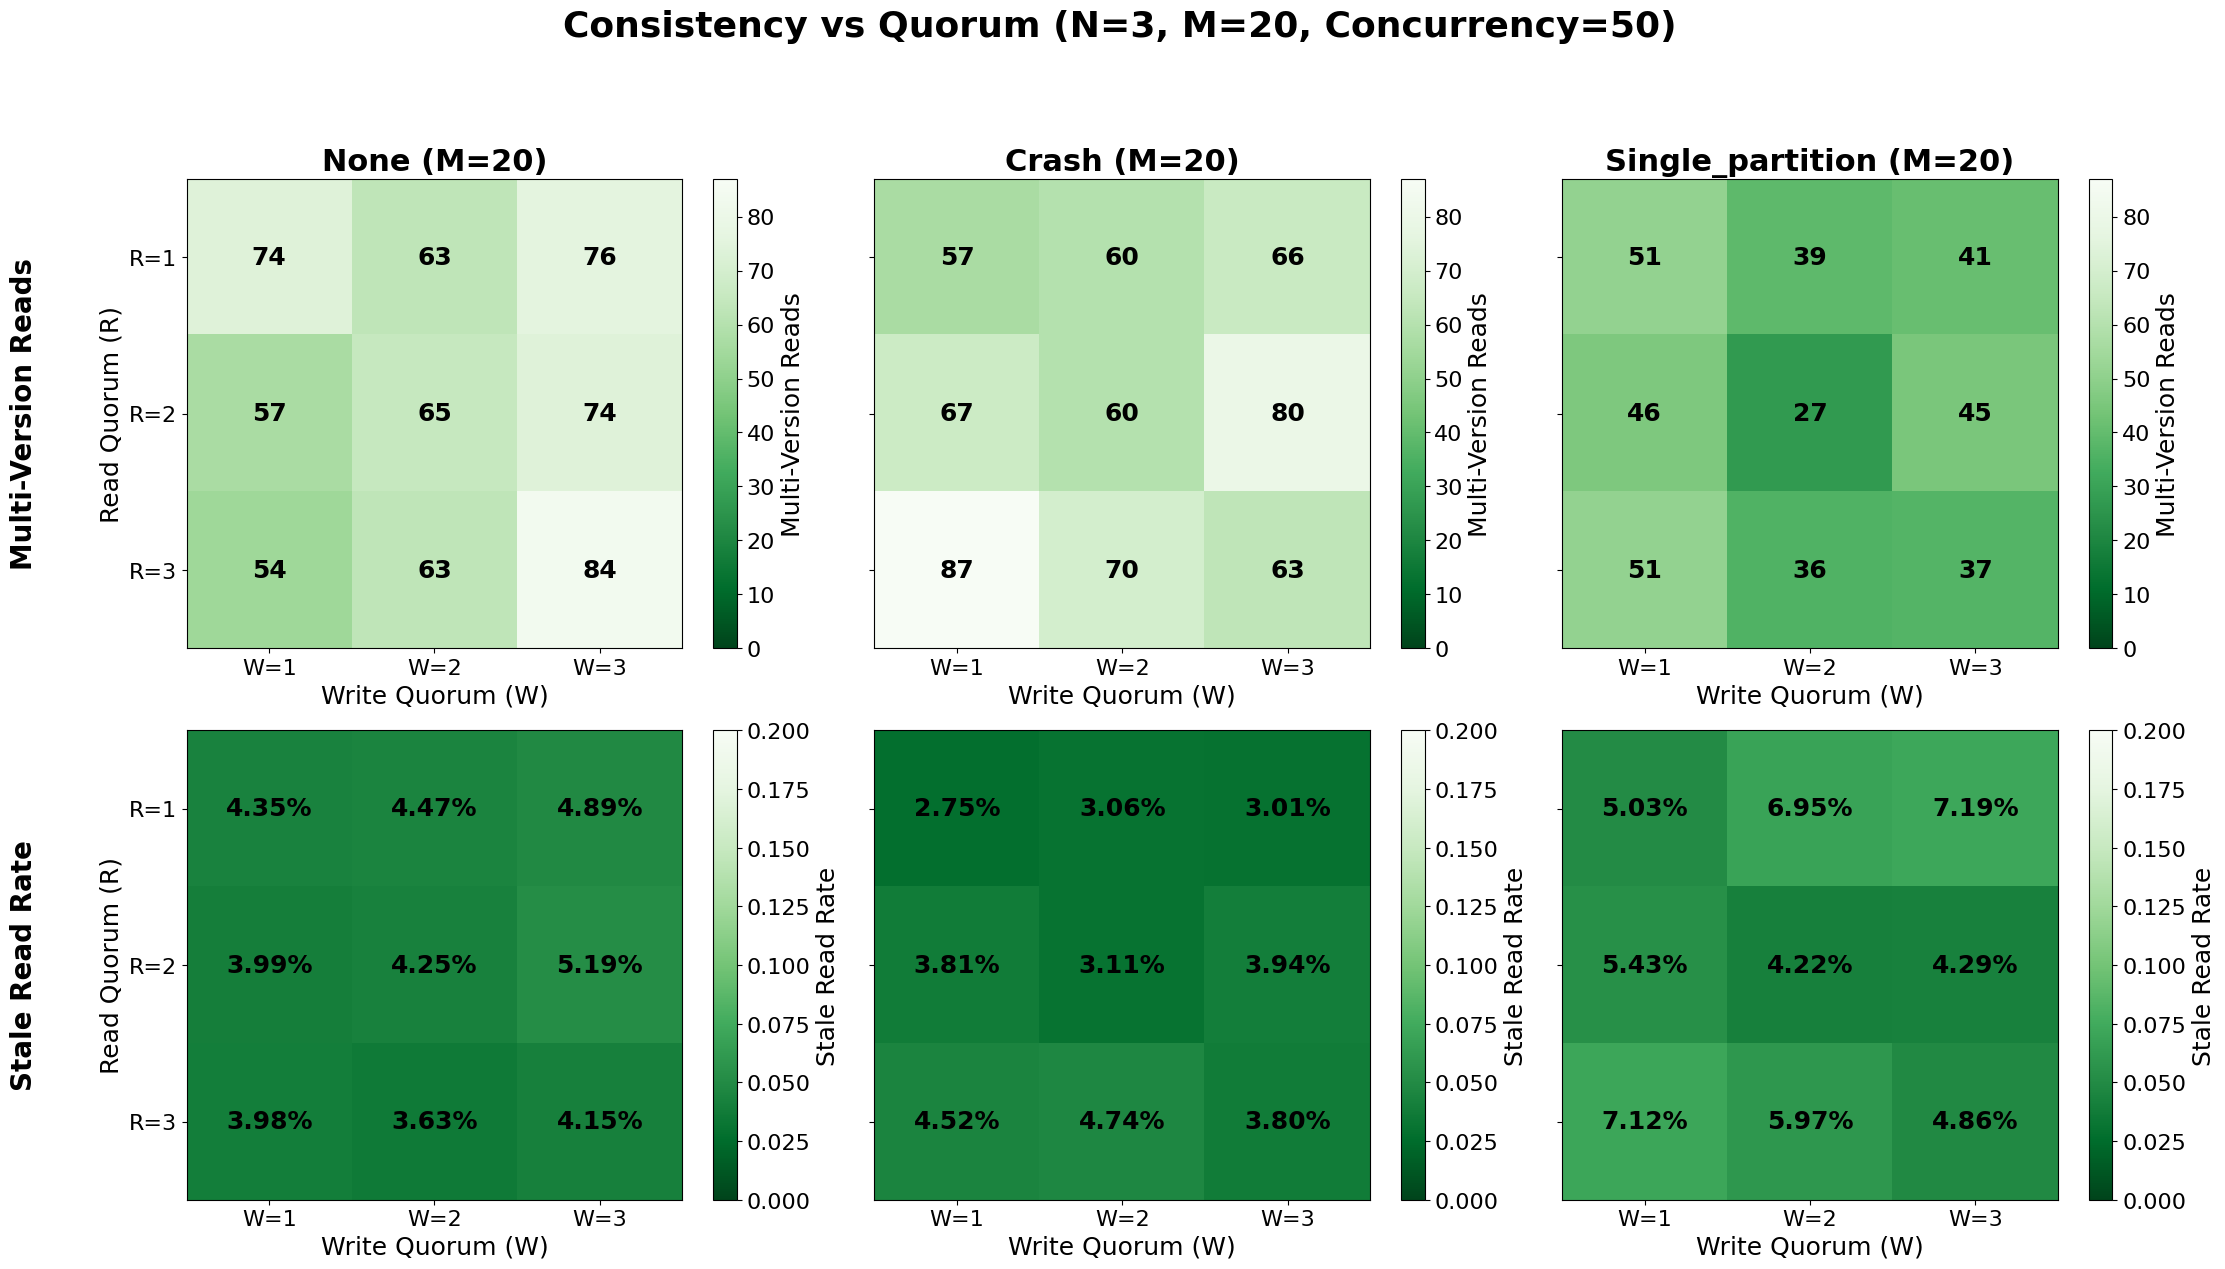

Saved: plots/consistency_quorum_heatmap_N3_M30_c50.png


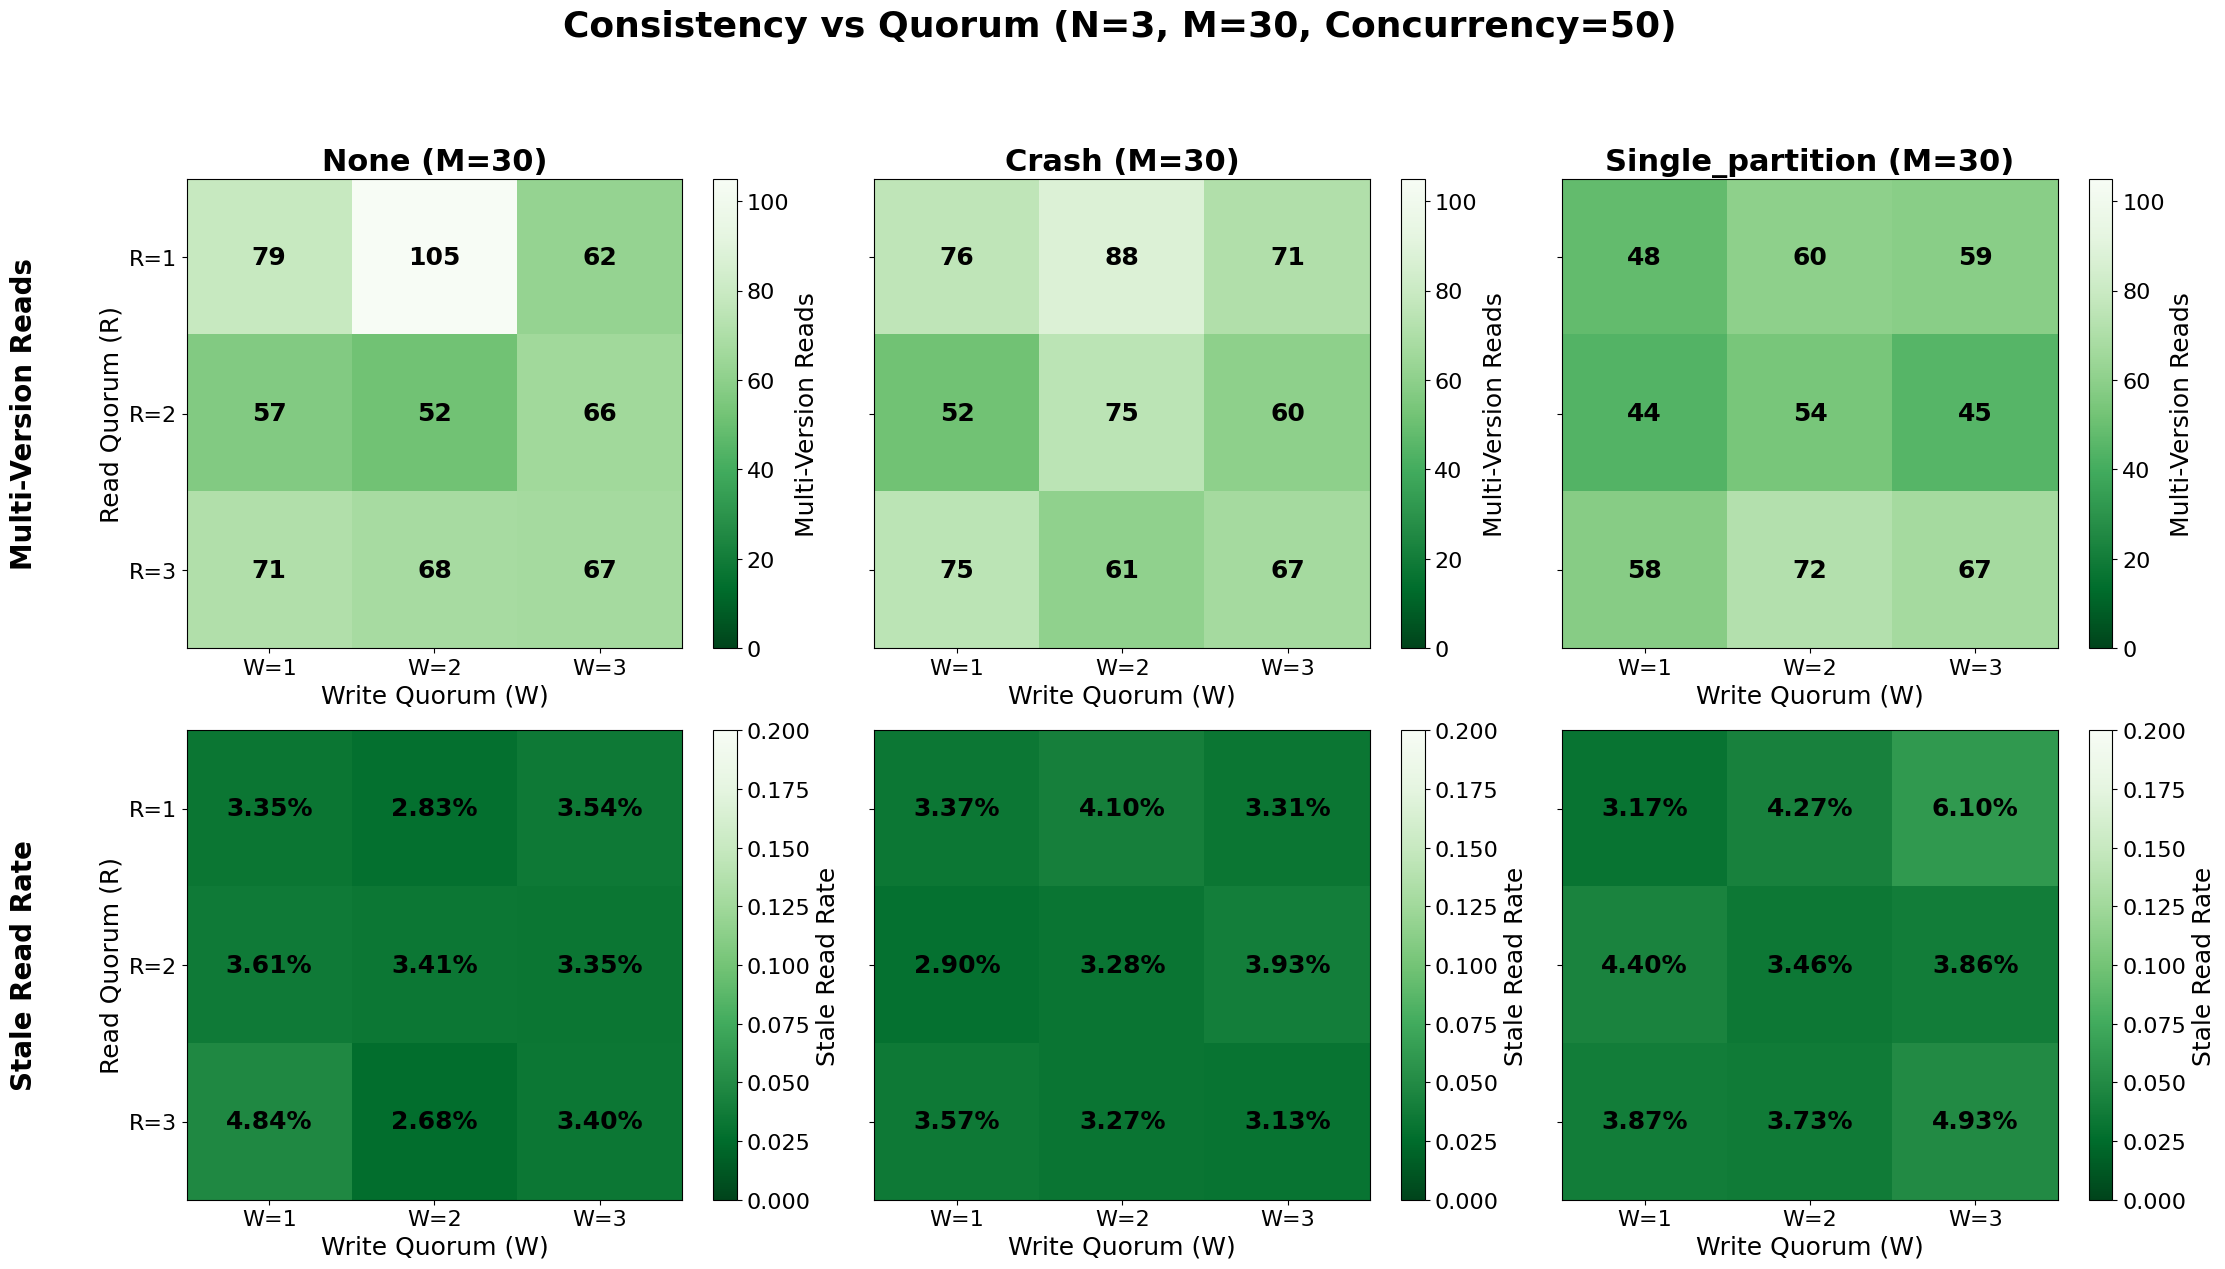

Saved: plots/consistency_quorum_heatmap_N3_M20_c100.png


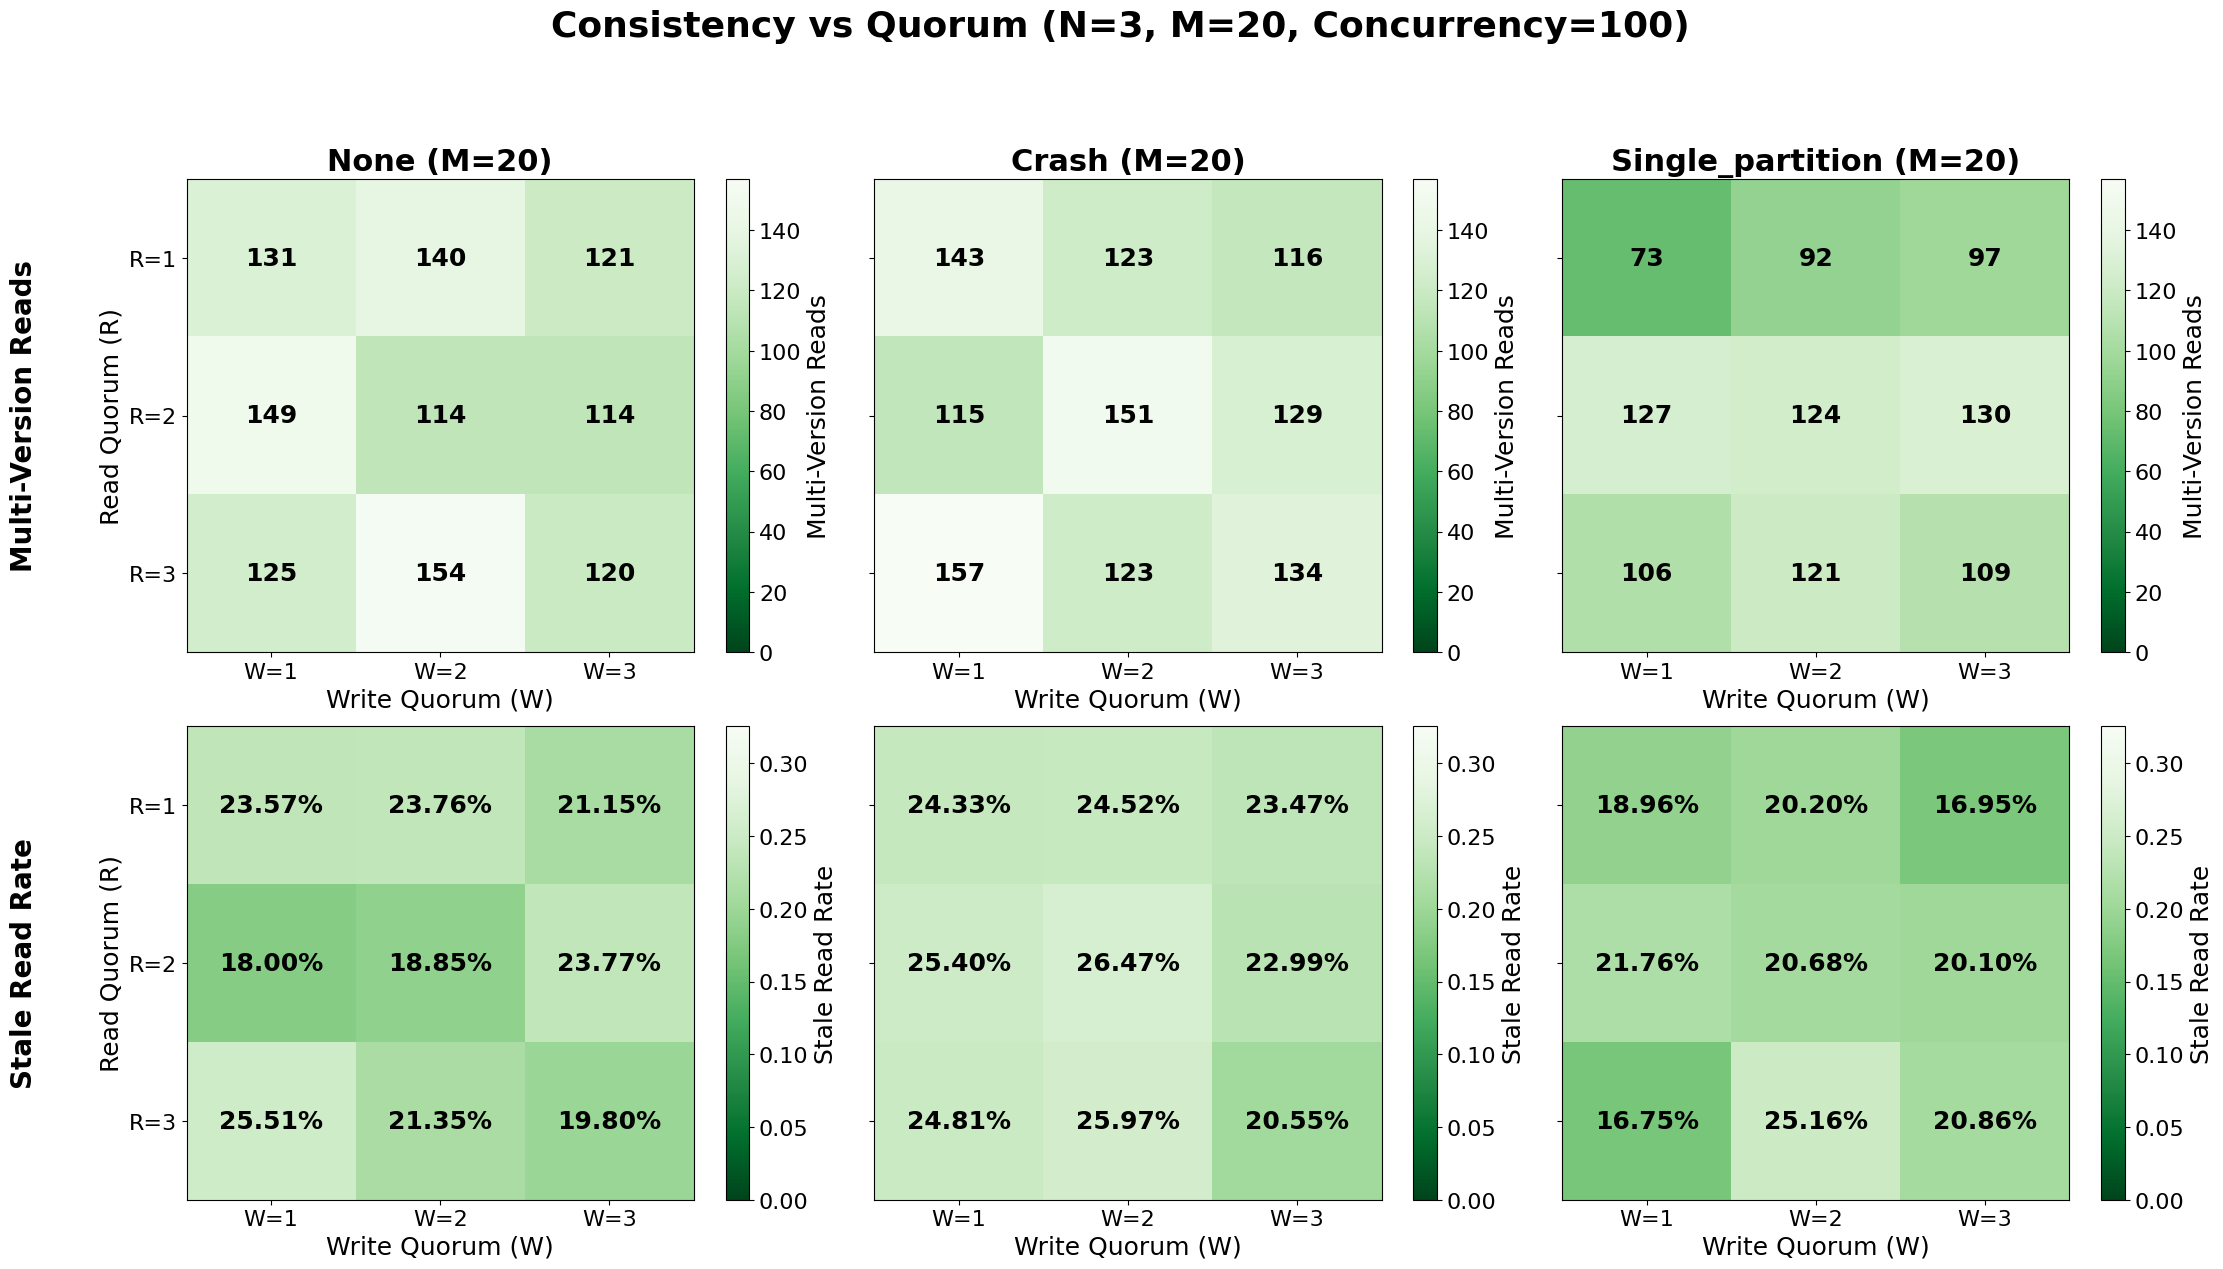

Saved: plots/consistency_quorum_heatmap_N5_M20_c50.png


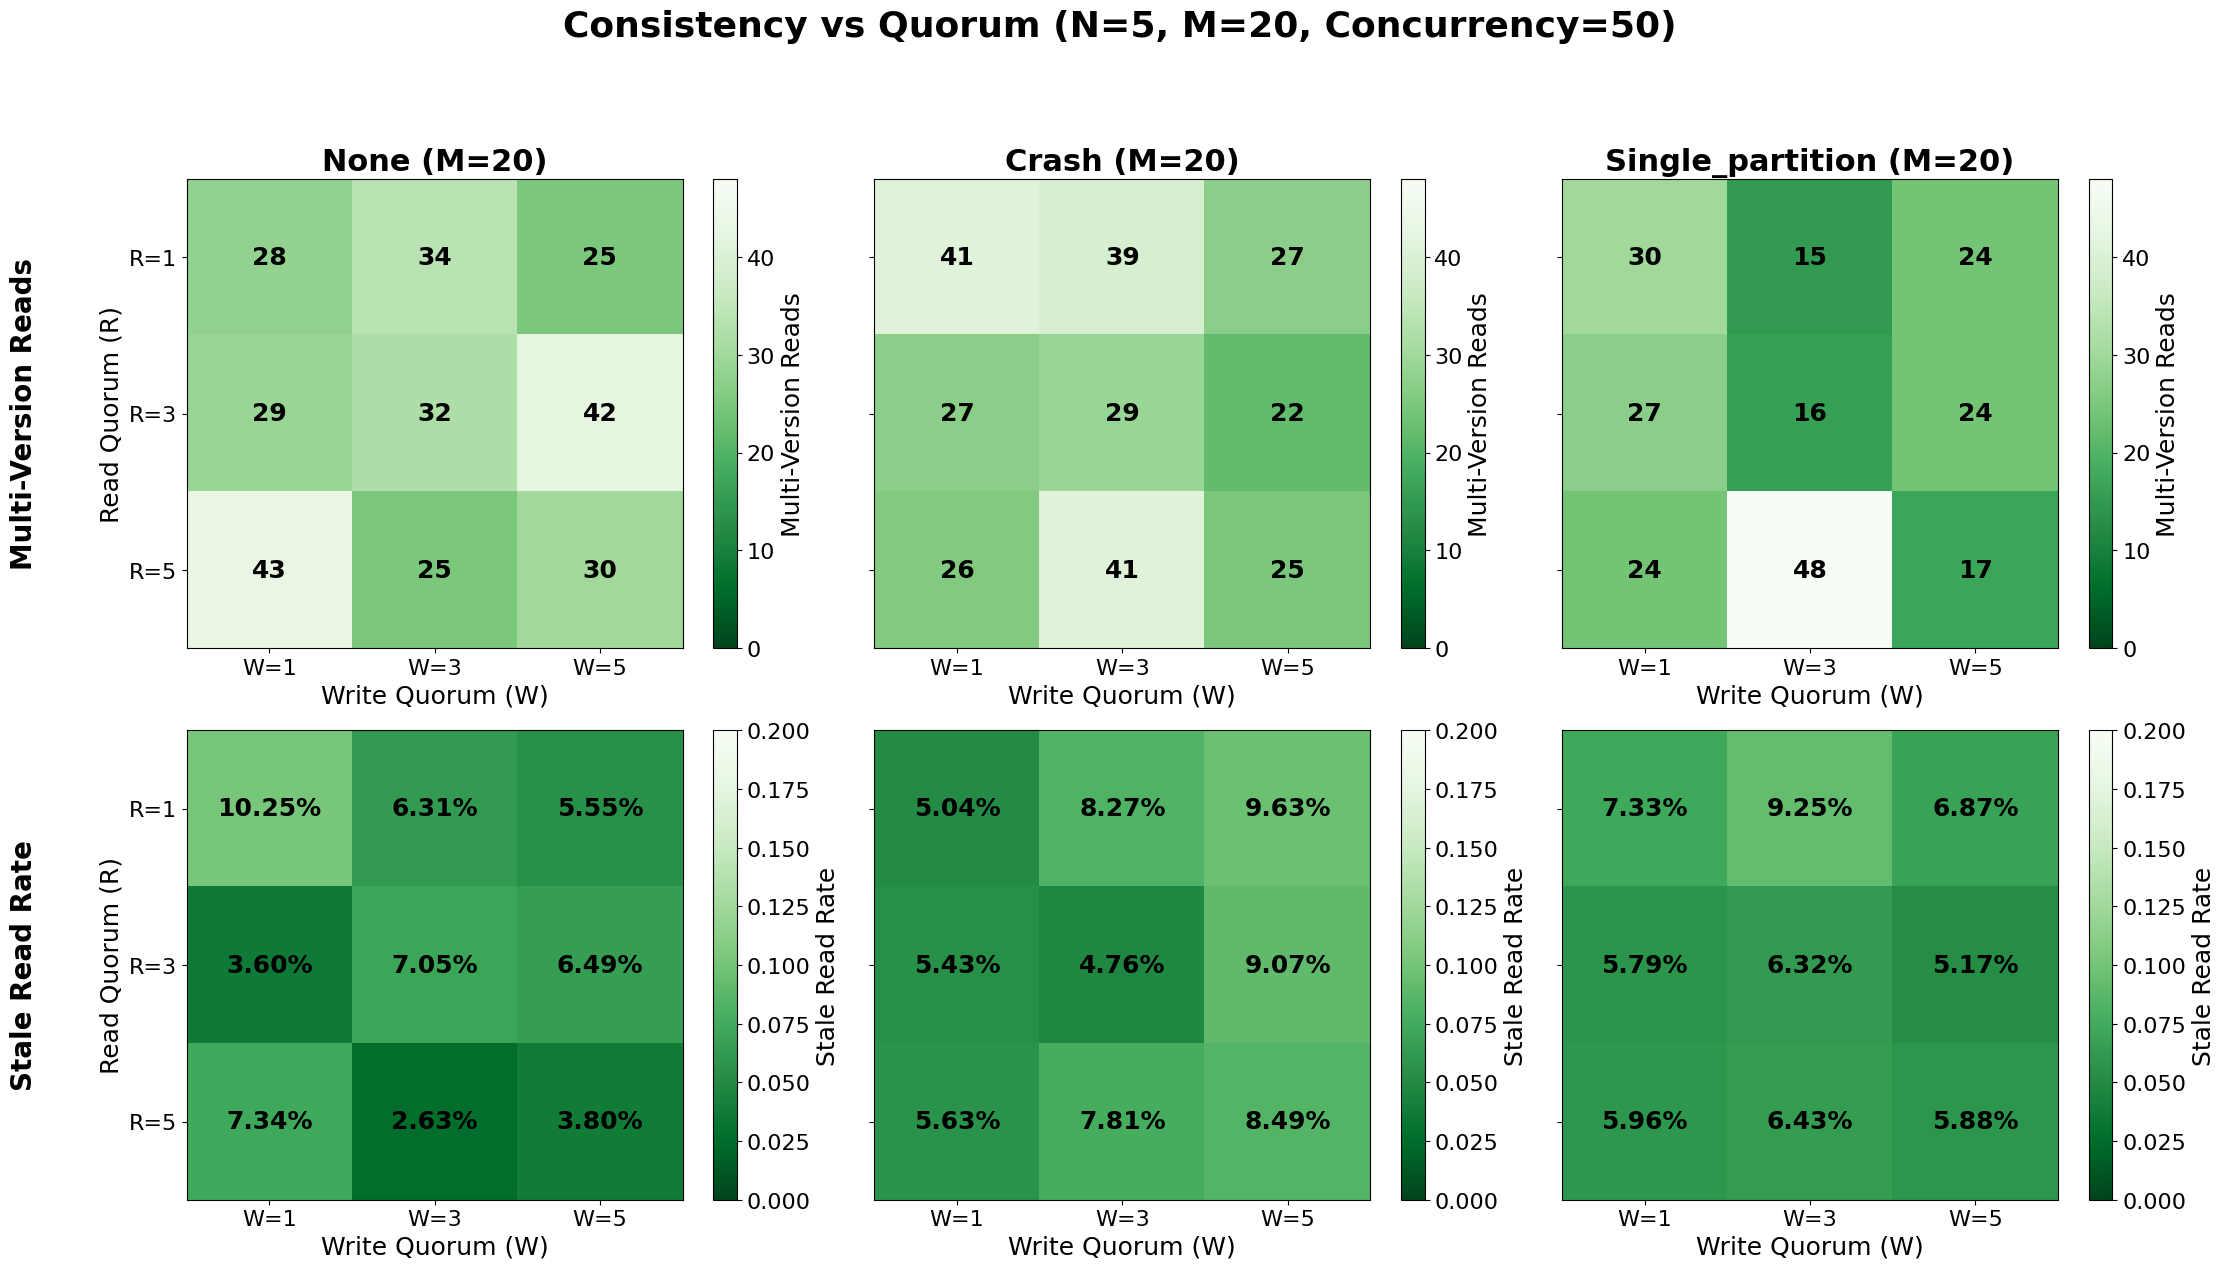

Saved: plots/consistency_quorum_heatmap_N5_M20_c100.png


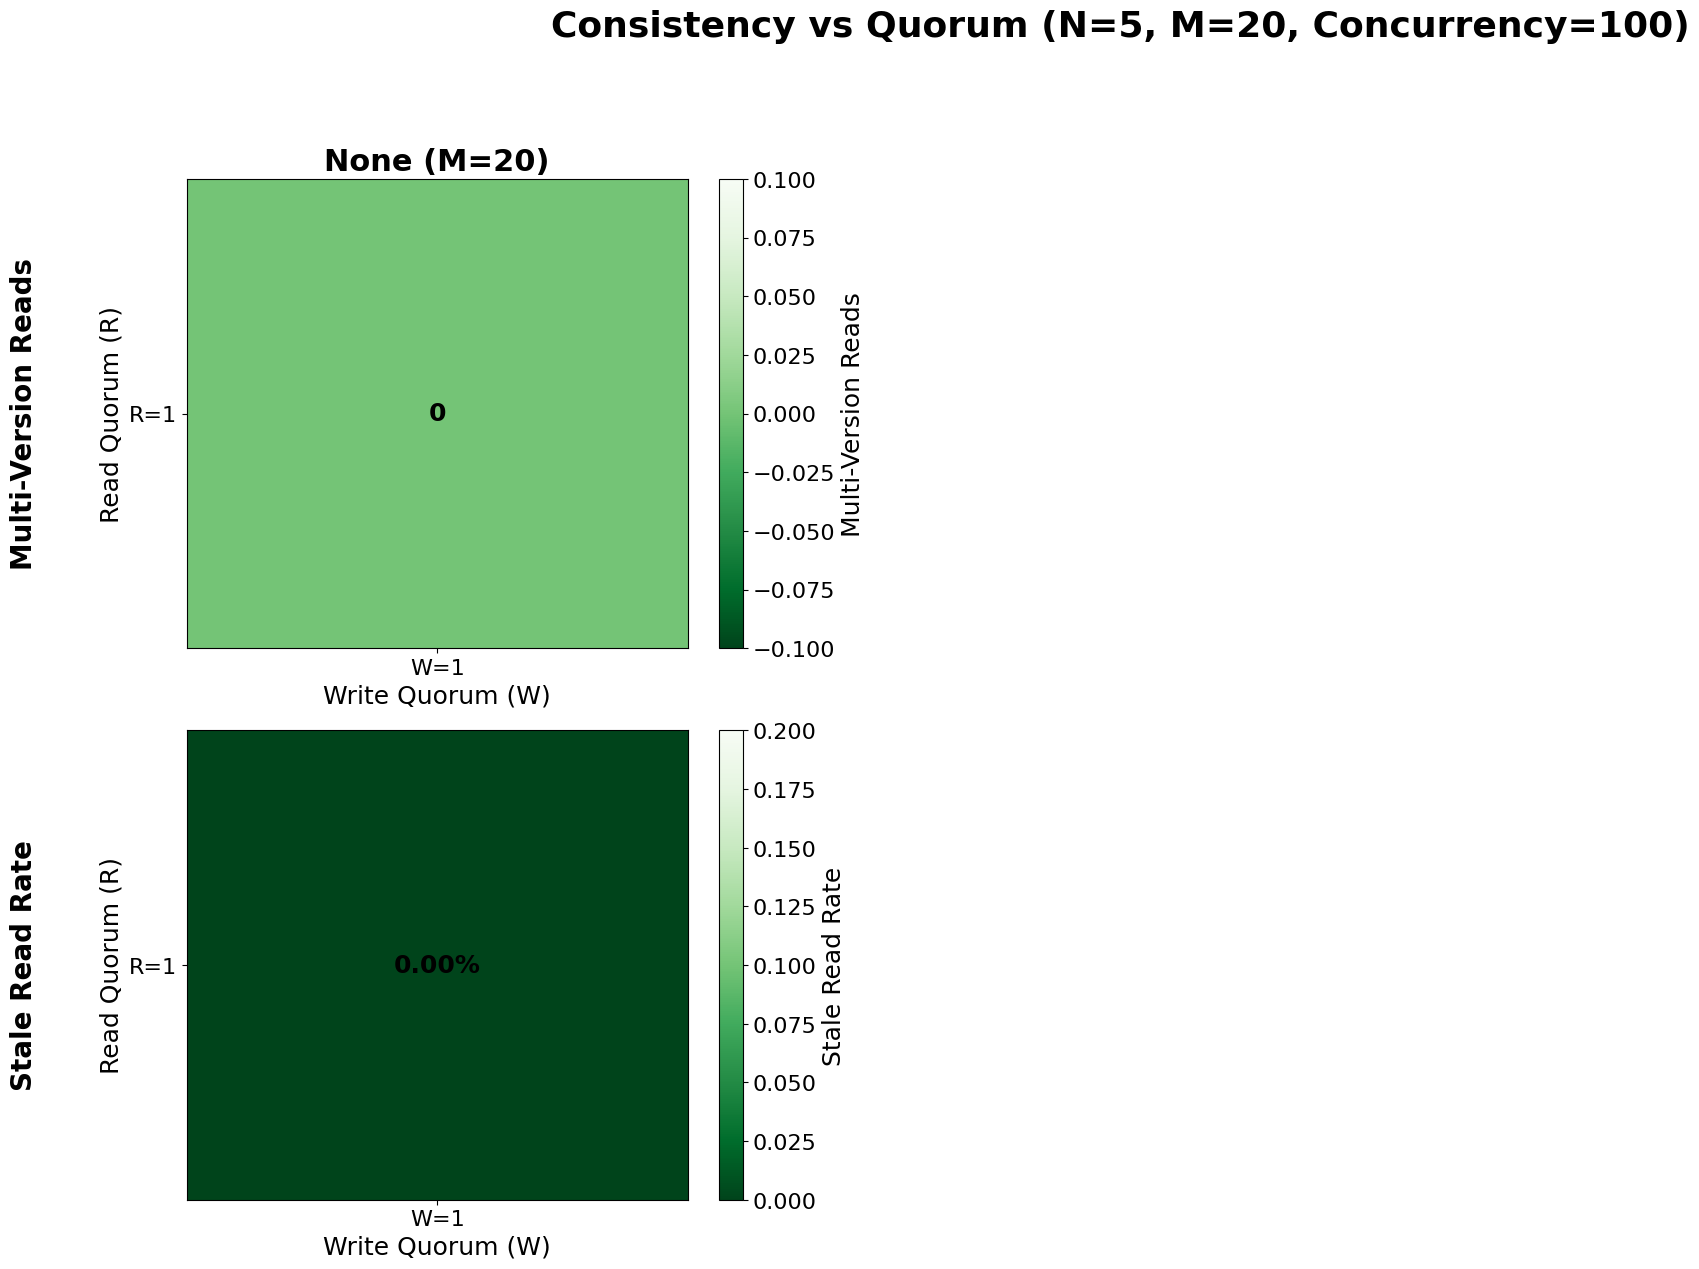

In [11]:
plot_consistency_vs_quorum(experiments, output_dir)